---

<h1 align="center">1. FACE ALIGNMENT TASK</h1>

---

## 1.0. Introduction

In this task, you have to implement face normalization and alignment. Most of the face images deceptively seem to be aligned, but since many face recognition algorithms are very sensitive to shifts and rotations, we need not only to find a face on the image but also normalize it. Besides, the neural networks usually used for recognition have fixed input size, so, the normalized face images should be resized as well.

There are six images of faces you have to normalize. In addition, you have the coordinates of the eyes in each of the pictures. You have to rotate the image so that the eyes are on the same height, crop the square box containing the face and transform it to the size $224\times 224.$ The eyes should be located symmetrically and in the middle of the image (on the height).

Here is an example of how the transformation should look like.

<img src = "https://cdn1.savepice.ru/uploads/2017/12/13/286e475ef7a4f4e59005bcf7de78742f-full.jpg">

### 1.1. Loading Data
You get the images and corresponding eyes coordinates for each person. You should implement the  function $\tt{load}$\_$\tt{faces}$\_$\tt{and}$\_$\tt{eyes}$ that reads the data and returns two dictionaries: the dictionary of images and the dictionary of eyes coordinates. Eyes coordinates is a list of two tuples $[(x_1,y_1),(x_2,y_2)]$.
Both dictionaries should have filenames as the keys.

$\tt{dir}$\_$\tt{name}$ is the path to the directory with face images, $\tt{eye}$\_$\tt{path}$ is the path to .pickle file with eyes coordinates. If these directory and file are located in the same directory as this notebook, then default arguments can be used.

In [2]:
def load_faces_and_eyes(dir_name = 'faces_imgs', eye_path = './eyes.pickle'):
    """ Your implementation """     
    pass
    
    
faces, eyes = load_faces_and_eyes()

### 1.2. Visualizing Original Images

Here is how the input images look like:

In [ ]:
visualize(faces.values())

### 2.0. Algorithm for Face Alignment

You may make the transformation using your own algorithm or by the following steps:
1. Find the angle between the segment connecting two eyes and horizontal line;
2. Rotate the image;
3. Find the coordinates of the eyes on the rotated image
4. Find the width and height of the box containing the face depending on the eyes coordinates
5. Crop the box and resize it to $224\times224$

In [4]:
#################################################################
# TODO: implement the function transform_face that rotates      #
#       the image so that the eyes have equal ordinate,         #
#       crops the square box containing face and resizes it.    #
#       You can use methods from skimage library if you need.   #
#       (2.5 points)                                              #
#################################################################

def transform_face(image, eyes):
    """ Your implementation """     
    return image

### 2.1. Visualizing Aligned Images 

In [ ]:
transformed_imgs = []
for i in faces:
    img = faces[i]
    eye = eyes[i]
    transformed = transform_face(img, eye)
    transformed_imgs.append(transformed)
    
visualize(transformed_imgs)

---

<h1 align="center">2. FACE DETECTION TASK</h1>

---

## 1.0. Introduction

In the first section, I work on creating my own deep face detector using the [FDDB dataset](http://vis-www.cs.umass.edu/fddb/) which has already been processed. This processing has been defined in file [./prepare_data.ipynb](prepare_data.ipynb) and consists of three steps -

1. Extracting bounding boxes from dataset. (Faces defined by [ellipsis](http://vis-www.cs.umass.edu/fddb/samples/) in the base dataset is not very useful for basic neural network learning.)
2. Removing images with big and small faces on one shoot.
3. Re-sizing images to so that bounding boxes have same size  (32 +/- 8 pixels).

Each image in this dataset is of shape (176, 176, 3). The original image of interest has been aligned at the top left and the rest of the image is a black background so that they are all equally sized.

Bounding boxes `bboxes` define the face in image and consists of 5 integer numbers: `[image_index, min_row, min_col, max_row, max_col]`. All bounding boxes have a width and height of 32 +/- 8 pixels.

`train_bboxes` and `val_bboxes` are lists of bboxes.

`train_shapes` and `val_shapes` are lists of interesting image shapes.

### 1.1. Importing Modules

In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from keras import backend as K

Using TensorFlow backend.


In [3]:
from matplotlib import pyplot as plt
import numpy as np
from skimage import transform

In [8]:
#from matplotlib.pyplot import imread

In [9]:
from get_data import load_dataset, unpack

### 1.2. Loading Dataset

In [10]:
# First run will download 30 MB data from github

train_images, train_bboxes, train_shapes = load_dataset("data", "train")
val_images, val_bboxes, val_shapes = load_dataset("data", "val")

In [11]:
train_images[0].shape

(176, 176, 3)

In [12]:
len(train_bboxes)

1051

In [13]:
train_bboxes[0]

array([ 0,  6, 27, 42, 54])

In [14]:
print(train_shapes[0])

[65 68]


In [15]:
val_images[0].shape

(176, 176, 3)

### 1.3. Visualizing Bounding Boxes

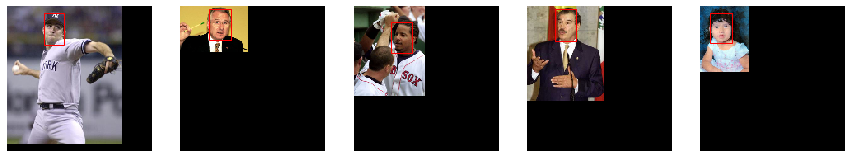

In [16]:
from graph import visualize_bboxes

visualize_bboxes(images=train_images, true_bboxes=train_bboxes)

## 2.0. Preparing Data

First, positive and negative samples must be extracted from image. Counts of positive and negative samples are similar, and all samples are of the same size. **NOTE:** Multiple faces may be present in the same image. 
1. All the faces must be extracted from each image and cropped to `SAMPLE_SHAPE` size. This set of extracted images are named `positive`.
2. Then, the `negative` set is extracted which is also of the same size.

*PSEUDO-CODE FOR EXTRACTION OF SAMPLES*

    negative_collection := []
    for i in range(negative_bbox_count):
        Select random image.
        image_shape := image_shapes[image_index]
        image_true_bboxes := true_bboxes[true_bboxes[:, 0] == image_index, 1:]
        
        #TRY_COUNT is a magic constant, for example, 100
        for j in TRY_COUNT:                                    
            Generate new_bbox within image_shape.
            
            if new_bbox is negative bbox for image_true_bboxes:
                Extract from image, new_bbox and resize to SAMPLE_SIZE negative_sample.
                Add negative sample to negative_collection.
                Break # for j in TRY_COUNT

### 2.1. Extracting Samples from Images

In [17]:
SAMPLE_SHAPE = (32, 32, 3)

In [ ]:
# To check if the new bounding box is not in the true bounding box list. 
# These bbox only have 4 ints [min_row, min_col, max_row, max_col] - image index is absent.
from scores import iou_score # Jaccard Index
def is_negative_bbox(new_bbox, true_bboxes, eps=1e-1):
    for bbox in true_bboxes:
        if iou_score(new_bbox, bbox) >= eps:
            return False
    return True


# To generate negative bounding box for image.
import skimage.transform
def gen_negative_bbox(image_shape, bbox_size, true_bboxes):
    height, width = bbox_size
    min_row = np.random.choice(image_shape[0] - height)
    max_row = min_row + height
    min_col = np.random.choice(image_shape[1] - width)
    max_col = min_col + width
    return [min_row, min_col, max_row, max_col]


# To retrieve positive and negative samples from image.
def get_positive_negative(images, true_bboxes, image_shapes, negative_bbox_count=None):
    positive = []
    negative = []
    image_count = image_shapes.shape[0]
    
    if negative_bbox_count is None:
        negative_bbox_count = len(true_bboxes)
    
    # A major part of the image may be black. Therefore negative samples are extracted only from [0:image_shape[0], 0:image_shape[1]].
    for true_bbox in true_bboxes:        
        image_index = true_bbox[0]
        pos_img = images[image_index][true_bbox[1]:true_bbox[1]+32, true_bbox[2]:true_bbox[2]+32, :]
        positive.append(pos_img)
        
    for i in range(negative_bbox_count):
        image_index = np.random.choice(len(images))
        image_shape = image_shapes[image_index]
        image_true_bboxes = true_bboxes[true_bboxes[:, 0] == image_index, 1:]
        for j in range(100):
            #bbox_index = np.random.choice(len(image_true_bboxes))
            #height = image_true_bboxes[bbox_index][2] - image_true_bboxes[bbox_index][0]
            #width = image_true_bboxes[bbox_index][3] - image_true_bboxes[bbox_index][1]
            bbox_size = (32, 32)
            new_bbox = gen_negative_bbox(image_shape, bbox_size, image_true_bboxes)
            if is_negative_bbox(new_bbox, image_true_bboxes):
                neg_img = images[image_index][new_bbox[0]:new_bbox[2], new_bbox[1]:new_bbox[3]]
                #neg_img = skimage.transform.resize(neg_img, SAMPLE_SHAPE, mode='reflect')
                negative.append(neg_img)
                break
    return positive, negative


def get_samples(images, true_bboxes, image_shapes):
"""
X - positive and negative samples.
Y - one-hot encoded list of 0s and 1s, 1 being the positive marker.
"""
    
    positive, negative = get_positive_negative(images=images, true_bboxes=true_bboxes, image_shapes=image_shapes)
    
    X = positive
    Y = [[0, 1]] * len(positive)
    X.extend(negative)
    Y.extend([[1, 0]] * len(negative))
    
    return np.array(X), np.array(Y)

In [21]:
X_train, Y_train = get_samples(train_images, train_bboxes, train_shapes)
X_val, Y_val = get_samples(val_images, val_bboxes, val_shapes)

### 2.2. Visualizing Samples

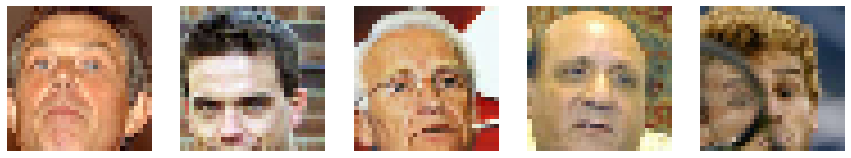

In [22]:
from graph import visualize_samples

visualize_samples(X_train[Y_train[:, 1] == 1])    # Contains faces
visualize_samples(X_train[Y_train[:, 1] == 0])    # Does not contain faces

## 3.0. Training Deep Face Classifier

First of all, we should train face classifier that checks if face represented on sample.

In [24]:
BATCH_SIZE = 64

### 3.1. Image Augmentation

Important thing in deep learning is augmentation. Sometimes, if your model are complex and cool, you can increase quality by using good augmentation.

Keras provide good [images preprocessing and augmentation](https://keras.io/preprocessing/image/). This preprocessing executes online (on the fly) while learning.

Of course, if you want using samplewise and featurewise center and std normalization you should run this transformation on predict stage. But you will use this classifier to fully convolution detector, in this case such transformation quite complicated, and we don't recommend use them in classifier.

For heavy augmentation you can use library [imgaug](https://github.com/aleju/imgaug). If you need, you can use this library in offline manner (simple way) and online manner (hard way). However, hard way is not so hard: you only have to write [python generator](https://wiki.python.org/moin/Generators), which returns image batches, and pass it to [fit_generator](https://keras.io/models/model/#fit_generator)

In [25]:
from keras.preprocessing.image import ImageDataGenerator # Usefull thing. Read the doc.

datagen = ImageDataGenerator(horizontal_flip=True,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             zoom_range=0.1,
                             samplewise_center = True,
                             samplewise_std_normalization = True
                            )
datagen.fit(X_train)

In [26]:
X_train.shape

(1968, 32, 32, 3)

### 3.2. Fitting classifier

For fitting you can use one of Keras optimizer algorithms. [Good overview](http://ruder.io/optimizing-gradient-descent/)

To choose best learning rate strategy you should read about EarlyStopping and ReduceLROnPlateau or LearningRateScheduler on [callbacks](https://keras.io/callbacks/) page of keras documentation, it's very useful in deep learning.

If you repeat architecture from some paper, you can find information about good optimizer algorithm and learning rate strategy in this paper. For example, every [keras application](https://keras.io/applications/) has link to paper, that describes suitable learning procedure for this specific architecture.

In [27]:
import os.path
from keras.optimizers import Adam
# Very usefull, pay attention
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

from graph import plot_history


def fit(model, datagen, X_train, Y_train, X_val, Y_val, model_name=None, output_dir="data/checkpoints", class_weight=None, epochs=50, lr=0.001, verbose=False):
    """Fit model.
    
    You can edit this function anyhow.
    """
    
    if verbose:
        model.summary()

    model.compile(optimizer=Adam(lr=lr), # You can use another optimizer
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    
    history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
                                  validation_data=(datagen.standardize(X_val), Y_val),
                                  epochs=epochs, steps_per_epoch=len(X_train) // BATCH_SIZE,
                                  callbacks=[ModelCheckpoint(os.path.join(output_dir, "{model_name}").format(model_name=model_name) + "-{epoch:02d}-{val_loss:.2f}.hdf5", save_best_only=True),
                                            ] if model_name is not None else [],
                                  class_weight=class_weight,
                      
                                 )  # starts training
    
    plot_history(history)

#### (first point out of three)

![lenet architecture](lenet_architecture.png)
LeCun, Y., Bottou, L., Bengio, Y. and Haffner, P., 1998. Gradient-based learning applied to document recognition. Proceedings of the IEEE, 86(11), pp.2278-2324.

Of course, you can use any another architecture, if want. Main thing is classification quality of your model.

Acceptable validation accuracy for this task is 0.92.

In [28]:
from keras.models import Model, Sequential
from keras.layers import Flatten, Dense, Activation, Input, Dropout, Activation, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D

def generate_model(sample_shape):
    # Classification model
    # You can start from LeNet architecture
    x = inputs = Input(shape=sample_shape)

    # Write code here
    x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.25)(x)

    # This creates a model
    predictions = Dense(2, activation='softmax')(x)
    return Model(inputs=inputs, outputs=predictions)

model = generate_model(SAMPLE_SHAPE)

In [29]:
print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        2432      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        25632     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               2622

#### Fit the model (second point out of three)

If you doesn't have fast video-card suitable for deep learning, you can first check neural network modifications with small value of parameter `epochs`, for example, 10, and then after selecting best model increase this parameter.
Fitting on CPU can be long, we suggest do it at bedtime.

Don't forget change model name.

In [30]:
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')

In [ ]:
# Attention: Windows implementation may cause an error here. In that case use model_name=None.
fit(model_name="myModel", model=model, datagen=datagen, X_train=X_train, X_val=X_val, Y_train=Y_train, Y_val=Y_val)

#### (third point out of three)

After learning model weights saves in folder `data/checkpoints/`.
Use `model.load_weights(fname)` to load best weights.

If you use Windows and Model Checkpoint doesn't work on your configuration, you should implement [your own Callback](https://keras.io/callbacks/#create-a-callback) to save best weights in memory and then load it back.

In [33]:
def get_checkpoint():
    return "data/checkpoints/myModel-45-0.04.hdf5"

model.load_weights(get_checkpoint())

## 4.0. Face Detection

If you have prepared classification architecture with high validation score, you can use this architecture for detection.

Convert classification architecture to fully convolution neural network (FCNN), that returns heatmap of activation.


### 4.1. Detector Model or Sliding Window

Now you should replace fully-connected layers with $1 \times 1$ convolution layers.

Every fully connected layer perform operation $f(Wx + b)$, where $f(\cdot)$ is nonlinear activation function, $x$ is layer input, $W$ and $b$ is layer weights. This operation can be emulated with $1 \times 1$ convolution with activation function $f(\cdot)$, that perform exactly same operation $f(Wx + b)$.

If there is `Flatten` layer with $n \times k$ input size before fully connected layers, convolution should have same $n \times k$ input size.
Multiple fully connected layers can be replaced with convolution layers sequence.

After replace all fully connected layers with convolution layers, we get fully convolution network. If input shape is equal to input size of previous network, output will have size $1 \times 1$. But if we increase input shape, output shape automatically will be increased. For example, if convolution step of previous network strides 4 pixels, increase input size with 100 pixels along all axis makes increase outputsize with 25 values along all axis. We got activation map of classifier without necessary extract samples from image and multiple calculate low-level features.

In total:
1. $1 \times 1$ convolution layer is equivalent of fully connected layer.
2. $1 \times 1$ convolution layers can be used to get activation map of classification network in "sliding window" manner.

We propose replace last fully connected layer with softmax actiovation to convolution layer with linear activation.It will be usefull to find good treshold. Of course, you can use softmax activation.

#### Example of replace cnn head:

##### Head before convert

![before replace image](before_convert.png)

##### Head after convert

![before replace image](after_convert.png)

On this images displayed only head. `InputLayer` should be replaced with convolution part exit.
Before convert network head takes fifty $8 \times 8$ feature maps and returns two values: probability of negative and positive classes. This output can be considered as activation map with size $1 \times 1$.

If input have size $8 \times 8$, output after convert would have $1 \times 1$ size, but input size is $44 \times 44$.
After convert network head returns one $37 \times 37$ activation map.

In [34]:
# FCNN

IMAGE_SHAPE = (176, 176, 3)

def generate_fcnn_model(image_shape):
    """After model compilation input size cannot be changed.
    
    So, we need create a function to have ability to change size later.
    """
    x = inputs = Input(image_shape)

    # Write code here
    x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (8, 8), activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Conv2D(64, (1, 1), activation='relu')(x)
    x = Dropout(0.25)(x)

    # This creates a model
    predictions = Conv2D(2, (1, 1), activation='linear')(x)
    return Model(inputs=inputs, outputs=predictions)

fcnn_model = generate_fcnn_model(IMAGE_SHAPE)

In [35]:
print(fcnn_model.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 176, 176, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 176, 176, 32)      2432      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 88, 88, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 88, 88, 32)        25632     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 44, 44, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 37, 37, 128)       262272    
_________________________________________________________________
dropout_3 (Dropout)          (None, 37, 37, 128)       0   

#### (1 point)

Then you should write function that copy weights from classification model to fully convolution model.
Convolution weights may be copied without modification, fully-connected layer weights should be reshaped before copy.

Pay attention to last layer.

In [36]:
def copy_weights(base_model, fcnn_model):
    """Set FCNN weights from base model.
    """
    
    new_fcnn_weights = []
    prev_fcnn_weights = fcnn_model.get_weights()
    prev_base_weights = base_model.get_weights()
    
    # Write code here
    for prev_fcnn_weight, prev_base_weight in zip(prev_fcnn_weights, prev_base_weights):
        new_fcnn_weights.append(prev_base_weight.reshape(prev_fcnn_weight.shape))
        
    fcnn_model.set_weights(new_fcnn_weights)

copy_weights(base_model=model, fcnn_model=fcnn_model)

### 4.2. Model Visualization

In [37]:
from graph import visualize_heatmap

In [38]:
predictions = fcnn_model.predict(np.array(datagen.standardize(val_images)))

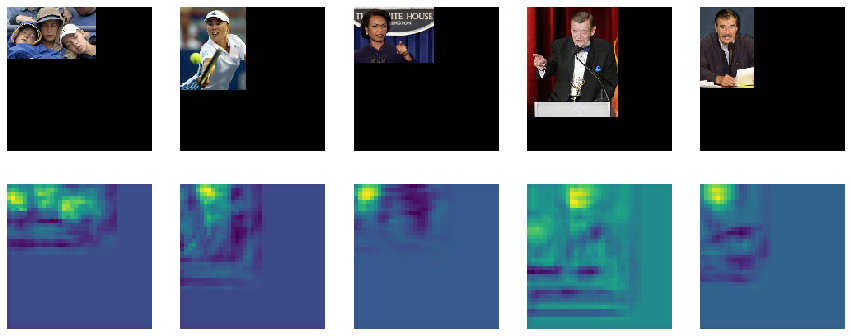

In [39]:
visualize_heatmap(val_images, predictions[:, :, :, 1])

### 4.3. Detector

First detector part is getting bboxes and decision function.
Greater decision function indicates better detector confidence.

This function should return pred_bboxes and decision_function:

- `pred bboxes` is list of 5 int tuples like `true bboxes`: `[image_index, min_row, min_col, max_row, max_col]`.
- `decision function` is confidence of detector for every pred bbox: list of float values, `len(decision function) == len(pred bboxes)` 
 
We propose resize image to `IMAGE_SHAPE` size, find faces on resized image with `SAMPLE_SHAPE` size and then resize them back.

In [40]:
# Detection
from skimage.feature import peak_local_max

def get_bboxes_and_decision_function(fcnn_model, images, image_shapes):      
    cropped_images = np.array([transform.resize(image, IMAGE_SHAPE, mode="reflect")  if image.shape != IMAGE_SHAPE else image for image in images])
    pred_bboxes, decision_function = [], []
   
    # Predict
    predictions = fcnn_model.predict(datagen.standardize(np.asarray(cropped_images,dtype='float')))

    # Write code here
    for i in range(len(predictions)):
        img_shape = image_shapes[i]
        local_max_list = peak_local_max(predictions[i][:,:,1], num_peaks=5, min_distance=3, exclude_border=False)
        for local_max_orig in local_max_list:
            local_max = ((local_max_orig + 2)*176/37).astype(int)
            
            if local_max[0] < img_shape[0] and local_max[1] < img_shape[1]:
                bbox = [i] + [local_max[0]-16,local_max[1]-16,local_max[0]+16,local_max[1]+16]
                
                pred_bboxes.append(bbox)
                decision_function.append(predictions[i, local_max_orig[0], local_max_orig[1], 1])
        
    return pred_bboxes, decision_function

### 4.4. Detector Visualization

In [41]:
from graph import show_bboxes
def visualize_bboxes1(images, pred_bboxes=None, true_bboxes=None, decision_function=None, n_cols=5, n_rows=1):
    plt.figure(figsize = (3*n_cols,3*n_rows))
    
    if pred_bboxes is not None:
        pred_bboxes = np.array(pred_bboxes, dtype=np.int32)
    if true_bboxes is not None:
        true_bboxes = np.array(true_bboxes, dtype=np.int32)

    for n,i in enumerate(range(5)):
        ax = plt.subplot(n_rows,n_cols,n+1)
        plt.axis('off')
        plt.imshow(images[i])

        if pred_bboxes is not None:
            _text = (["{0:0.2f}".format(decision_function[prec]) for prec in np.where(pred_bboxes[:, 0] == i)[0]]
                     if decision_function is not None else None)
            show_bboxes(bboxes=pred_bboxes[pred_bboxes[:, 0] == i, 1:], ax=ax, color="blue", text=_text)
        
        if true_bboxes is not None:
            show_bboxes(bboxes=true_bboxes[true_bboxes[:, 0] == i, 1:], ax=ax, color="red")
    plt.show()

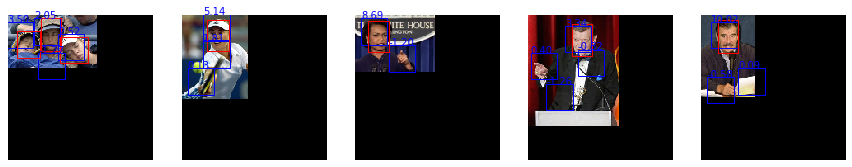

In [42]:
pred_bboxes, decision_function = get_bboxes_and_decision_function(fcnn_model=fcnn_model, images=val_images, image_shapes=val_shapes)

visualize_bboxes1(images=val_images,
                 pred_bboxes=pred_bboxes,
                 true_bboxes=val_bboxes,
                 decision_function=decision_function
                )

### 4.5. Detector Score

Write [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall) graph.

You can use function `best_match` to extract matching between prediction and ground truth, false positive and false negative samples. 

*PSEUDO-CODE FOR CALCULATION OF PRECISION-RECALL GRAPH*
    
    # Initialization for first step threshold := -inf
    tn := 0 # We haven't any positive sample
    fn := |false_negative| # But some faces wasn't been detected
    tp := |true_bboxes| # All true bboxes have been caught
    fp := |false_positive| # But also some false positive samples have been caught
    
    Sort decision_function and pred_bboxes with order defined by decision_function
    y_true := List of answers for "Is the bbox have matching in y_true?" for every bbox in pred_bboxes
    
    for y_on_this_step in y_true:
        # Now we increase threshold, so some predicted bboxes makes positive.
        # If y_t is True then the bbox is true positive else bbox is false positive
        # So we should
        Update tp, tn, fp, fn with attention to y_on_this_step
        
        Add precision and recall point calculated by formula through tp, tn, fp, fn on this step
        Threshold for this point is decision function on this step.

In [43]:
from scores import best_match
from graph import plot_precision_recall

def precision_recall_curve(pred_bboxes, true_bboxes, decision_function):
    precision, recall, thresholds = [], [], []
    
    # Write code here
    threshold = min(decision_function) - 1
    max_th = max(decision_function) + 1
    num_steps = 100
    th_step = (max_th - threshold)/num_steps

    sorted_boxes = [[x]+y for y,x in sorted(zip(pred_bboxes,decision_function),key=lambda pair:pair[1])]
    
    for step in range(num_steps):        
        pred_bboxes_th = [x[1:] for x in sorted_boxes if x[0]>threshold]
        if len(pred_bboxes_th) > 0:
            matched, false_negative, false_positive = best_match(pred_bboxes_th, true_bboxes, decision_function)
        else:
            break
        
        prec = len(matched)/(len(matched)+len(false_positive))
        rec = len(matched)/(len(matched)+len(false_negative))
        
        thresholds.append(threshold)
        recall.append(rec)
        precision.append(prec)
        threshold += th_step
    
    return precision, recall, thresholds

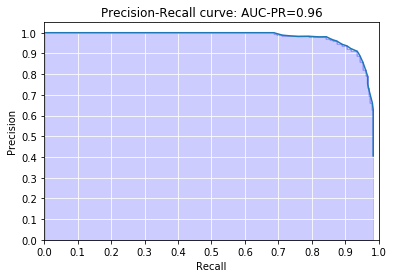

In [44]:
precision, recall, thresholds = precision_recall_curve(pred_bboxes=pred_bboxes, true_bboxes=val_bboxes, decision_function=decision_function)
plot_precision_recall(precision=precision, recall=recall)

### 4.6. Threshold

Next step in detector creating is select threshold for decision_function.
Every possible threshold presents point on recall-precision graph.

Select threshold for `recall=0.85`.

In [45]:
def get_threshold(thresholds, recall):
    return thresholds[np.argmax(np.asarray(recall) <= 0.85)]

THRESHOLD = get_threshold(thresholds, recall)

In [46]:
def detect(fcnn_model, images, image_shapes, threshold, return_decision=True):
    """Get bboxes with decision_function not less then threshold."""
    pred_bboxes, decision_function = get_bboxes_and_decision_function(fcnn_model, images, image_shapes)   
    result, result_decision = [], []
    
    # Write code here
    for i in range(len(pred_bboxes)):
        if decision_function[i] >= threshold:
            result.append(pred_bboxes[i])
            result_decision.append(decision_function[i])
    
    if return_decision:
        return result, result_decision
    else:
        return result

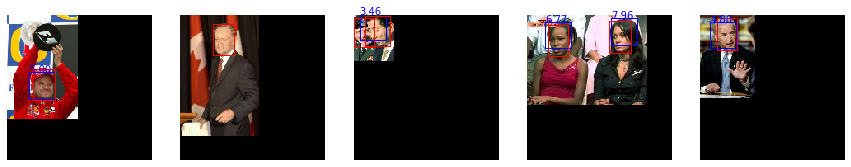

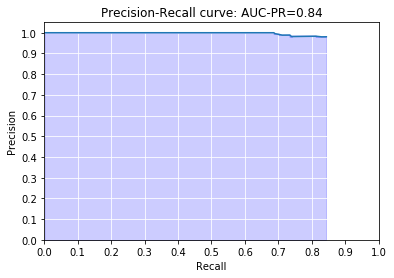

In [47]:
pred_bboxes, decision_function = detect(fcnn_model=fcnn_model, images=val_images, image_shapes=val_shapes, threshold=THRESHOLD, return_decision=True)

visualize_bboxes(images=val_images,
                 pred_bboxes=pred_bboxes,
                 true_bboxes=val_bboxes,
                 decision_function=decision_function
                )

precision, recall, thresholds = precision_recall_curve(pred_bboxes=pred_bboxes, true_bboxes=val_bboxes, decision_function=decision_function)
plot_precision_recall(precision=precision, recall=recall)

### 4.6. Testing

Last detector preparation step is testing.

Attention: to avoid over-fitting, after testing algorithm you should run [./prepare_data.ipynb](prepare_data.ipynb), and start all fitting from beginning.

Detection score (in graph header) should be 0.85 or greater.

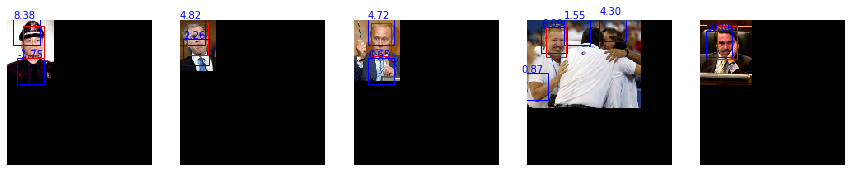

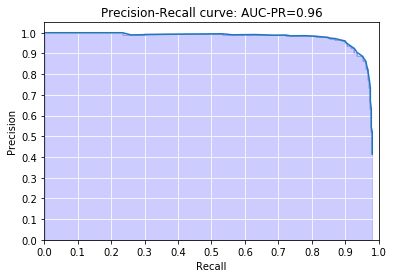

In [48]:
test_images, test_bboxes, test_shapes = load_dataset("data", "test")

# We test get_bboxes_and_decision_function becouse we want pay attention to all recall values
pred_bboxes, decision_function = get_bboxes_and_decision_function(fcnn_model=fcnn_model, images=test_images, image_shapes=test_shapes)

visualize_bboxes(images=test_images,
                 pred_bboxes=pred_bboxes,
                 true_bboxes=test_bboxes,
                 decision_function=decision_function
                )

precision, recall, threshold = precision_recall_curve(pred_bboxes=pred_bboxes, true_bboxes=test_bboxes, decision_function=decision_function)
plot_precision_recall(precision=precision, recall=recall)

## 5.0. Conclusion

### 5.1. Testing Algorithm with Original Dataset

Test your algorithm on original (not scaled) data.
Visualize bboxes and plot precision-recall curve.

In [ ]:
# First run will download 523 MB data from github

original_images, original_bboxes, original_shapes = load_dataset("data", "original")

### 5.2. Hard negative mining

Upgrade the score with [hard negative mining](https://www.reddit.com/r/computervision/comments/2ggc5l/what_is_hard_negative_mining_and_how_is_it/).

A hard negative is when you take that falsely detected patch, and explicitly create a negative example out of that patch, and add that negative to your training set. When you retrain your classifier, it should perform better with this extra knowledge, and not make as many false positives.

In [ ]:
# Write this function
def hard_negative(train_images, image_shapes, train_bboxes, X_val, Y_val, base_model, fcnn_model):
    pass

In [ ]:
hard_negative(train_images=train_images, image_shapes=train_shapes, train_bboxes=train_bboxes, X_val=X_val, Y_val=Y_val, base_model=model, fcnn_model=fcnn_model)

In [ ]:
model.load_weights("data/checkpoints/...")

In [ ]:
copy_weights(base_model=model, fcnn_model=fcnn_model)

pred_bboxes, decision_function = get_bboxes_and_decision_function(fcnn_model=fcnn_model, images=val_images, image_shapes=val_shapes)

visualize_bboxes(images=val_images,
                 pred_bboxes=pred_bboxes,
                 true_bboxes=val_bboxes,
                 decision_function=decision_function
                )

precision, recall, thresholds = precision_recall_curve(pred_bboxes=pred_bboxes, true_bboxes=val_bboxes, decision_function=decision_function)
plot_precision_recall(precision=precision, recall=recall)

### 5.3. Multi Scale Detector

Write and test detector with [pyramid representation][pyramid].
[pyramid]: https://en.wikipedia.org/wiki/Pyramid_(image_processing)

1. Resize images to predefined scales.
2. Run detector with different scales.
3. Apply non-maximum supression to detection on different scales.

References:
1. [E. H. Adelson,C. H. Anderson, J. R. Bergen, P. J. Burt, J. M. Ogden: Pyramid methods in image processing](http://persci.mit.edu/pub_pdfs/RCA84.pdf)
2. [PETER J. BURT, EDWARD H. ADELSON: The Laplacian Pyramid as a Compact Image Code](http://persci.mit.edu/pub_pdfs/pyramid83.pdf)

In [ ]:
def multiscale_detector(fcnn_model, images, image_shapes):
    return []

### 5.4. What Next?

Next steps in deep learning detection are R-CNN, Faster R-CNN and SSD architectures. This architecture realization is quite complex and therefore is not covered in this task.

---

<h1 align="center">3. FACIAL KEYPOINTS DETECTION TASK</h1>

---

In this task you will create facial keypoint detector based on CNN regressor.

## 1.1. Loading Data

Script `get_data.py` unpacks data — images and labelled points. 6000 images are located in `images` folder and keypoint coordinates are in `gt.csv` file. Run the cell below to unpack data.

In [ ]:
from get_data import unpack
unpack('facial-keypoints-data.zip')

Now you have to read `gt.csv` file and images from `images` dir. File `gt.csv` contains header and ground truth points for every image in `images` folder. It has 29 columns. First column is a filename and next 28 columns are `x` and `y` coordinates for 14 facepoints. We will make following preprocessing:
1. Scale all images to resolution $100 \times 100$ pixels.
2. Scale all coordinates to range $[-0.5; 0.5]$. To obtain that, divide all x's by width (or number of columns) of image, and divide all y's by height (or number of rows) of image and subtract 0.5 from all values.

Function `load_imgs_and_keypoint` should return a tuple of two numpy arrays: `imgs` of shape `(N, 100, 100, 3)`, where `N` is the number of images and `points` of shape `(N, 28)`.

In [25]:
### Useful routines for preparing data
from numpy import array, zeros
import numpy as np
from os.path import join
from skimage.color import gray2rgb
from skimage.io import imread, imshow
from skimage.transform import resize
import os
import pandas as pd


def load_imgs_and_keypoints(dirname='facial-keypoints'):
    
    images = []
    heights = []
    widths = []
    images_folder = r'data\images'
    for i in os.listdir(images_folder):
        img_path = join(images_folder, i)
        img = imread(img_path)
        img = gray2rgb(img)
        
        heights.append(img.shape[0])
        widths.append(img.shape[1])
        
        img = resize(img, (100, 100))
        images.append(img)
        
    df = pd.read_csv(r"data\gt.csv")
    df.drop(columns=['filename'], inplace=True)
    
    cnt = 0
    for i in df.columns:
        if cnt % 2 == 0:
            df.loc[:, i] /= heights
        else:
            df.loc[:, i] /= widths
            
    coordinates_np = df.to_numpy()
    coordinates_np -= 0.5
    
    images_np = np.array(images)
    assert images_np.shape == (len(images), 100, 100, 3)
    assert coordinates_np.shape == (len(images), 28)
    
    return images_np, coordinates_np
    
    
imgs, points = load_imgs_and_keypoints()

array([-0.30534351, -0.30534351, -0.01526718, -0.27099237,  0.14503817,
       -0.2519084 ,  0.27480916, -0.30152672, -0.24045802, -0.20610687,
       -0.17557252, -0.21374046, -0.08015267, -0.1870229 ,  0.11068702,
       -0.16793893,  0.15267176, -0.19847328,  0.23664122, -0.17938931,
        0.09541985,  0.04961832, -0.14885496,  0.16412214,  0.03435115,
        0.1870229 ,  0.14122137,  0.18320611])

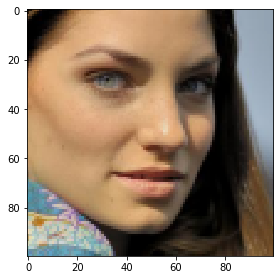

### 1.2. Visualizing Data

In [ ]:
# Example of output
%matplotlib inline
from skimage.io import imshow
imshow(imgs[0])
points[0]

Let's prepare a function to visualize points on image. Such function obtains two arguments: an image and a vector of points' coordinates and draws points on image (just like first image in this notebook).

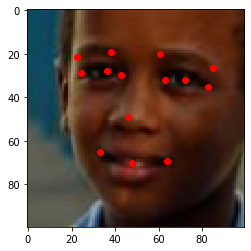

In [27]:
import matplotlib.pyplot as plt
# Circle may be useful for drawing points on face
# See matplotlib documentation for more info
from matplotlib.patches import Circle

def visualize_points(img, points):
    # Write here function which obtains image and normalized
    # coordinates and visualizes points on image
    fig, ax = plt.subplots()
    ax.imshow(img)
    for i in range(len(points) // 2):
        plt.plot((points[i*2] + 0.5)*100, (points[i*2 + 1] + 0.5)*100, 'o', color='r')
    
visualize_points(imgs[1], points[1])

### 1.3. Splitting Training and Validation Set

Run the following code to obtain train/validation split for training neural network.

In [30]:
from sklearn.model_selection import train_test_split
imgs_train, imgs_val, points_train, points_val = train_test_split(imgs, points, test_size=0.1)

### 1.4. Data Augmentation

For better training we will use simple data augmentation — flipping an image and points. Implement function flip_img which flips an image and its' points. Make sure that points are flipped correctly! For instance, points on right eye now should be points on left eye (i.e. you have to mirror coordinates and swap corresponding points on the left and right sides of the face). VIsualize an example of original and flipped image.

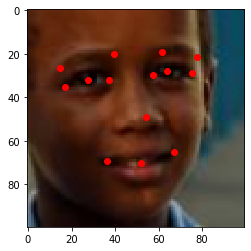

In [43]:
-0.30534351, -0.30534351, -0.01526718, -0.27099237,  0.14503817

def flip_img(img, points):
    # Write your code for flipping here
    flipped_img = np.fliplr(img)
    flipped_points = points.copy()
    for i in range(len(points) // 2):
        flipped_points[2*i] *= -1
    
    return flipped_img, flipped_points
    
f_img, f_points = flip_img(imgs[1], points[1])
visualize_points(f_img, f_points)

Time to augment our training sample. Apply flip to every image in training sample. As a result you should obtain two arrays: `aug_imgs_train` and `aug_points_train` which contain original images and points along with flipped ones.

In [65]:
# Write your code here
aug_imgs_train = []
aug_points_train = []
for i in range(len(imgs_train)):
    f_img, f_points = flip_img(imgs[i], points[i])
    aug_imgs_train.append(f_img)
    aug_points_train.append(f_points)
    
aug_imgs_train = np.array(aug_imgs_train)
aug_points_train = np.array(aug_points_train)

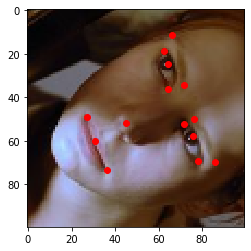

In [66]:
visualize_points(aug_imgs_train[2], aug_points_train[2])

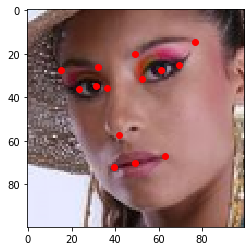

In [67]:
visualize_points(aug_imgs_train[3], aug_points_train[3])

## 2.0. CNN Regressor


### 2.1. Defining Network Architecture

Now let's define neural network regressor. It will have 28 outputs, 2 numbers per point. The precise architecture is up to you. We recommend to add 2-3 (`Conv2D` + `MaxPooling2D`) pairs, then `Flatten` and 2-3 `Dense` layers. Don't forget about ReLU activations. We also recommend to add `Dropout` to every `Dense` layer (with p from 0.2 to 0.5) to prevent overfitting.


In [68]:
from keras.models import Sequential
from keras.layers import (
    Conv2D, MaxPooling2D, Flatten,
    Dense, Dropout
)

model = Sequential()
# Define here your model

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(28, activation='linear'))

### 2.2. Training Model

Time to train! Since we are training a regressor, make sure that you use mean squared error (mse) as loss. Feel free to experiment with optimization method (SGD, Adam, etc.) and its' parameters.

In [69]:
# ModelCheckpoint can be used for saving model during training.
# Saved models are useful for finetuning your model 
# See keras documentation for more info
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD, Adam

# Choose optimizer, compile model and run training
model.compile(loss='mse',
              optimizer=Adam(),
              metrics=['mse'])

model.fit(aug_imgs_train, aug_points_train,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_data=(imgs_val, points_val))


Train on 5400 samples, validate on 600 samples
Epoch 1/10
5400/5400 [==============================] - 45s 8ms/step - loss: 0.0139 - mse: 0.0139 - val_loss: 0.0658 - val_mse: 0.0658
Epoch 2/10
5400/5400 [==============================] - 44s 8ms/step - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0622 - val_mse: 0.0622
Epoch 3/10
5400/5400 [==============================] - 41s 8ms/step - loss: 0.0045 - mse: 0.0045 - val_loss: 0.0612 - val_mse: 0.0612
Epoch 4/10
5400/5400 [==============================] - 43s 8ms/step - loss: 0.0039 - mse: 0.0039 - val_loss: 0.0636 - val_mse: 0.0636
Epoch 5/10
5400/5400 [==============================] - 45s 8ms/step - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0648 - val_mse: 0.0648
Epoch 6/10
5400/5400 [==============================] - 47s 9ms/step - loss: 0.0030 - mse: 0.0030 - val_loss: 0.0650 - val_mse: 0.0650
Epoch 7/10
5400/5400 [==============================] - 43s 8ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0661 - val_mse: 0.0661
Epoch 8

## 3.0. Conclusion

### 3.1. Visualizing Results

Now visualize neural network results on several images from validation sample. Make sure that your network outputs different points for images (i.e. it doesn't output some constant).

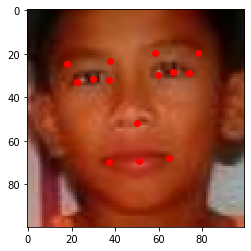

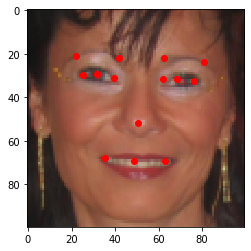

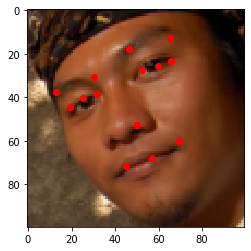

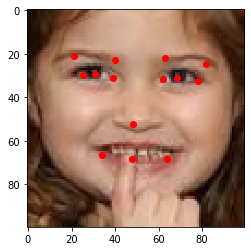

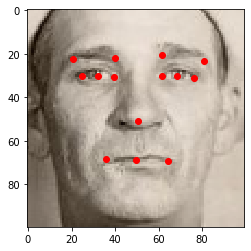

In [70]:
# Example of output
predicted_points = model.predict(imgs_val)
for i in range(5):
    idx = np.random.choice(imgs_val.shape[0])
    visualize_points(imgs_val[idx], predicted_points[idx])

---

<h1 align="center">4A. FACIAL RECOGNITION TASK</h1>

---

## 1.0. Introduction

In this task, you have to construct face recognizer based on features extracted from the neural network. The task consists of two parts: image classification and video classification. In the first one you should classify distinct images and in the second one you will deal with short video sequences.

### 1.1. Loading Modules

In [ ]:
pip install tensorflow

     |▎                               | 4.5 MB 380 kB/s eta 0:22:26

In [1]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Flatten, Dense, Activation
from tensorflow.keras.layers import Convolution2D, MaxPooling2D
from tensorflow.keras import backend as K

ModuleNotFoundError: No module named 'tensorflow'

In [2]:
%pylab inline
from matplotlib import pyplot as plt
import numpy as np
import cv2
import os
from copy import copy
from collections import Counter

ModuleNotFoundError: No module named 'matplotlib'

### 1.2. Loading Data for Image Classification

First of all, you have you have to read the data. Run the cell below to unpack data.

In [3]:
from get_data import unpack
unpack('Face_Recognition_data.zip')

Implement function $\tt{load}$\_$\tt{image}$\_$\tt{data}$. It should return a tuple of 4 dictionaries: the first two are training images and labels, the second two are testing ones. The keys of the dictionaries are the names of the image files and the values are 3-dimensional numpy arrays (for images) or strings with the names (for labels).

$\tt{dir}$\_$\tt{name}$ is the name of directory with data for image classification. If 'Face_Recofnition_data' directory is located in the same directory as this notebook, then the default value can be used.

In [3]:
import os
from os.path import join
import pandas as pd
from skimage.io import imread

In [4]:
def load_image_data(dir_name = 'Face_Recognition_data/image_classification'):
    """Your implementation"""
    x_train, y_train, x_test, y_test = {}, {}, {}, {}
    for filename in os.listdir(join(dir_name, 'train', 'images')):
        img = imread(join(dir_name, 'train', 'images', filename))
        if len(img.shape) == 2:
            img = gray2rgb(img)
        x_train[filename] = img
    
    df_train = pd.read_csv(join(dir_name, 'train', 'y_train.csv'))
    for filename, class_id in zip(df_train.filename, df_train.class_id):
        y_train[filename] = class_id
    
    
    
    for filename in os.listdir(join(dir_name, 'test', 'images')):
        img = imread(join(dir_name, 'test', 'images', filename))
        if len(img.shape) == 2:
            img = gray2rgb(img)
        x_test[filename] = img
    
    df_test = pd.read_csv(join(dir_name, 'test', 'y_test.csv'))
    for filename, class_id in zip(df_test.filename, df_test.class_id):
        y_test[filename] = class_id
        
        
    return x_train, y_train, x_test, y_test
#     pass

In [5]:
x_train, y_train, x_test, y_test = load_image_data()
print ('%d'%len(x_train), '\ttraining images')
print ('%d'%len(x_test), '\ttesting images')

661 	training images
808 	testing images


### 1.3. Visualizing Image Data

In [6]:
def visualize(data, labels, function = lambda x:x[0], n_cols = 5, n_rows=1):
    figure(figsize = (3*n_cols,3*n_rows))
    for n,i in enumerate(np.random.choice(list(data.keys()), size = n_cols*n_rows)):
        plt.subplot(n_rows,n_cols,n+1)
        plt.axis('off')
        plt.imshow(function([data[i]]))
        plt.title(labels[i])
    plt.show()

That is how the data looks like.

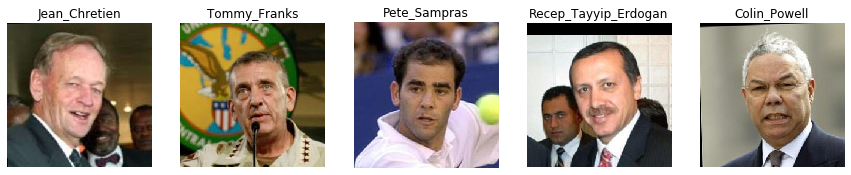

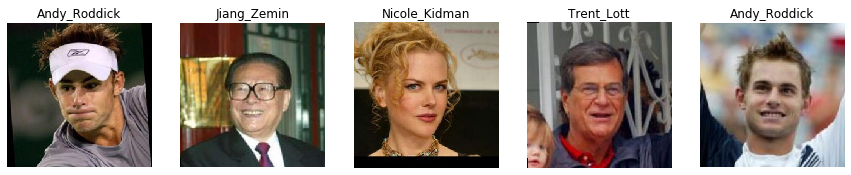

In [7]:
visualize(x_train, y_train)
visualize(x_test, y_test)

### 1.4. Loading Data for Video Classification

Let us now read the video classification data, as well. You have to implement function to load video data.

Function $\tt{load}$\_$\tt{video}$\_$\tt{data}$ should also return a tuple of 4 dictionaries: the first two are training images and labels, the second two are testing videos and labels. The training data is in the same format as in image classification task. The keys of testing data and labels are video ids and the values are the lists of frames and the strings with names, respectively.

In [8]:
def load_video_data(dir_name = 'Face_Recognition_data/video_classification'):
    """Your implementation"""
    video_train, train_labels, video_test, test_labels = {}, {}, {}, {}
    
    
    df_train = pd.read_csv(join(dir_name, 'train', 'y_train.csv'))
    
    for index, row in df_train.iterrows():
        try:
            img = imread(join(dir_name, 'train', 'images', row.filename))
            if len(img.shape) == 2:
                img = gray2rgb(img)
            video_train[row.filename] = img
            train_labels[row.filename] = row.class_id
        except:
            pass

    df_test = pd.read_csv(join(dir_name, 'test', 'y_test.csv'))
    
    for index, row in df_test.iterrows():
        video_test[row.filename] = []
        for filename in os.listdir(join(dir_name, 'test', 'videos', str(row.filename))):
            try:
                img = imread(join(dir_name, 'test', 'videos', str(row.filename), filename))
                if len(img.shape) == 2:
                    img = gray2rgb(img)
                video_test[row.filename].append(img)
                test_labels[row.filename] = row.class_id
            except:
                pass

    return video_train, train_labels, video_test, test_labels

In [9]:
video_train, train_labels, video_test, test_labels = load_video_data()
print ('%d'%len(video_train), '\ttraining images')
print ('%d'%len(video_test), '\ttesting videos')

729 	training images
70 	testing videos


### 1.5. Visualizing Video Data

In [10]:
assert video_test.keys() == test_labels.keys(), 'Missmatch'

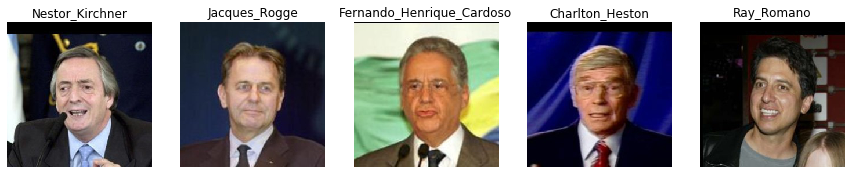

In [11]:
visualize(video_train, train_labels)

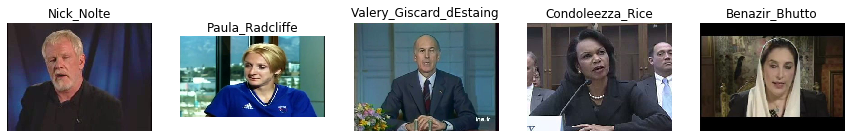

In [15]:
visualize({i:video_test[i][1] for i in video_test}, test_labels)

## 2.0. Preprocessing

You have to implement preprocessing function in the cell below.
Getting a list of images as an input the this function should detect the face on each image, find the facial keypoints () and then crop and normalize the image according to these keypoints. The output of this function is the list of images which contain only the aligned face and should be converted to the tensor of the shape $(N, 224, 224, 3)\ $ where $N$ is the length of the initial list. You can add extra arguments to the preprocess function if necessary (i.e. flag $\tt{is}$\_$\tt{video}$ to determine if the list of images is video sequence or not).

For face detection and facial keypoint regression you can use your models from the previous tasks.

In [12]:
# !pip install dlib

In [16]:
import dlib
from cv2 import resize
detector = dlib.get_frontal_face_detector()

In [17]:
def preprocess_imgs(imgs):
    """Your implementation"""
    res = []
    for img in imgs:
        dets = detector(img)
        if len(dets) == 0:
            cropped = resize(img, (224,224))
            res.append(cropped)
            continue
        for d in dets:
            top = d.top()
            bottom = d.bottom()
            right = d.right()
            left = d.left()
            height = bottom - top
            width = right - left
            
            # Original dlib face detector has small face area, enlarge it to achieve better
            # performance combined with follwing neural network.
            
            scale = 0.2
            top = max(0, int(top - height*scale))
            bottom = min(img.shape[0], int(bottom + height*scale))
            left = max(0, int(left - width*scale))
            right = min(img.shape[1], int(right + width*scale))
            
            if top >= 0 and left >=0:
                cropped = img[top:bottom, left:right, :]
                cropped = cv2.resize(cropped, (224,224))
                res.append(cropped)
                break
    
    if len(res) == 0:
        imshow(imgs[0])
    
    return res
#     pass

### 2.1. Visualization of preprocessing

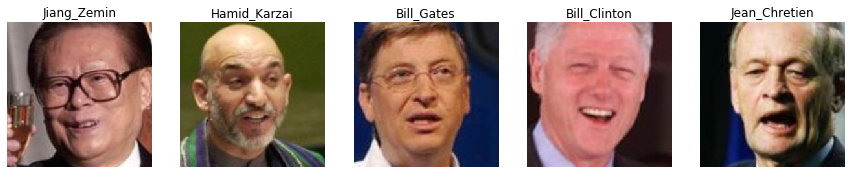

In [18]:
visualize(x_train, y_train, function = lambda x:preprocess_imgs(x)[0])

The neural network is already trained on the other face dataset. You should use this network as feature extractor to get descriptors of the faces. You can choose any hidden layer you need (or several layers) to extract features and any classification method.

In [19]:
import h5py
from tensorflow.keras.models import load_model
model = load_model('face_recognition_model.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0         
_________________________________________________________________
conv3_1 (Conv2D)             (None, 56, 56, 256)       2

Here is an example of using the network as feature extractor. The shape of input tensor has to be (n_images, 224, 224, 3), so you can input several images simultaneously and get their face descriptors of shape (n_images, n_components).

In [20]:
def get_layer_output(images, layer = 'fc6'):
    assert len(images.shape)==4, 'Wrong input dimentionality!'
    assert images.shape[1:]==(224,224,3), 'Wrong input shape!'
    
    network_output = model.get_layer(layer).output
    feature_extraction_model = Model(model.input, network_output)
    
    output = feature_extraction_model.predict(images)
    return output

In [ ]:
img = cv2.resize(x_train['0.jpg'], (224,224)).reshape(1,224,224,3)
out = get_layer_output(img)
print (out.shape)

## 3.0. Training Classifier


You have to implement class $\tt{Classifier}$ with methods $\tt{fit}$, $\tt{classify}$\_$\tt{images}$ and $\tt{classify}$\_$\tt{videos}$ in the cell below. 
The method $\tt{Classifier.fit}$ gets two dictionaries as input: train images and labels, and trains the classifier to predict the person shown on the image.
$\tt{Classifier.classify}$\_$\tt{images}$ gets the dictionary of test images (with filenames as keys) as input and should return the dictionary of the predicted labels.
$\tt{Classifier.classify}$\_$\tt{videos}$ is similar to the previous one, but gets the dictionary of test videos (with video as keys) as input.

To classify video you can combine the predictions for its frames any way you want (averaging, voting, etc.).
If video classification takes too long you can use face detector not in all the frames but every few frames while preprocessing video frames. 
Besides, sometimes the face is hardly detected on the image and the frame in which the detector works wrong can add noise to the prediction. Hence, the result of the prediction without using such frames may be better.

In [21]:
import random
from tqdm import tqdm

In [22]:
from sklearn.neighbors import KNeighborsClassifier as kNN
from sklearn.svm import SVC
from skimage.io import imread
import cv2
from os.path import join
from collections import Counter

class Classifier():
    def __init__(self, nn_model, layer='fc7'):
        """Your implementation"""
        network_output = nn_model.get_layer(layer).output
        self.feature_extraction_model = Model(nn_model.input, network_output)
        self.clf = kNN(n_neighbors=5, weights='distance')


    def fit(self, train_imgs, train_labels):
        """Your implementation"""
        train_X = []
        train_y = []
        for k, v in train_imgs.items():
            pre_img = preprocess_imgs([v])[0]
            pre_img = pre_img[np.newaxis, ...]
            train_X_features = self.feature_extraction_model.predict(pre_img)
            train_X.append(train_X_features)
            train_y.append(train_labels[k])
            
        train_X = np.asarray(train_X)
        train_X = np.reshape(train_X, (-1, 4096))
        train_y = np.asarray(train_y)

        self.clf.fit(train_X,train_y)


    def classify_images(self, test_imgs):
        """Your implementation"""
        res = {}
        for k, v in tqdm(test_imgs.items()):
            pre_img = preprocess_imgs([v])[0]
            pre_img = pre_img[np.newaxis, ...]
            test_img_features = self.feature_extraction_model.predict(pre_img)
            predicted_y = self.clf.predict(test_img_features)[0]
            res[k] = predicted_y
       
        return res
       
        
    def classify_videos(self, test_video):
        """Your implementation"""
        detector = dlib.get_frontal_face_detector()
        res = {}
        for k, v in tqdm(test_video.items()):
            table = Counter()
            for img in random.sample(v, 5):
                if len(detector(img, 1)) < 1:
                    continue
                pre_img = preprocess_imgs([img])[0]
                pre_img = pre_img[np.newaxis, ...]
                test_img_features = self.feature_extraction_model.predict(pre_img)
                predicted_y = self.clf.predict(test_img_features)[0]
                table[predicted_y] += 1
            res[k] = max(table, key=lambda x:table[x])

        return res

Now we can build the classifier, fit it and use to predict the labels of testing images.

In [23]:
img_classifier = Classifier(model)
img_classifier.fit(x_train, y_train)

In [24]:
y_out = img_classifier.classify_images(x_test)

100%|██████████| 808/808 [06:11<00:00,  2.18it/s]


## 4.0. Conclusion

### 4.1. Accuracy of Image Classification

Let us check the accuracy of your classification. To obtain 1 point for that rubric your implementation must have accuracy at least 0.90, to obtain 2 points — at least 0.95.

In [25]:
def check_test(output, gt):
    correct = 0.
    total = len(gt)
    for k, v in gt.items():
        if output[k] == v:
            correct += 1
    accuracy = correct / total

    return 'Classification accuracy is %.4f' % accuracy

In [26]:
print (check_test(y_out, y_test))

Classification accuracy is 0.9616


### 4.2. Accuracy of Video Classification

Let us check the quality of video classification. To obtain 1 point for that rubric your implementation must have accuracy at least 0.80, to obtain 2 points — at least 0.85.

In [27]:
video_classifier = Classifier(model)
video_classifier.fit(video_train, train_labels)

In [ ]:
y_video_out = video_classifier.classify_images(video_train)

In [29]:
print ('Training', check_test(y_video_out, train_labels))

Training Classification accuracy is 1.0000


In [30]:
y_video_out = video_classifier.classify_videos(video_test)

100%|██████████| 70/70 [02:58<00:00,  2.56s/it]


In [31]:
len(y_video_out)

70

In [32]:
[x for x in range(len(y_video_out.values())) if y_video_out[x] != test_labels[x]]

[28, 35, 43, 49, 54]

In [33]:
print(check_test(y_video_out, test_labels))

Classification accuracy is 0.9286


---

<h1 align="center">4B. FACIAL RECOGNITION TASK</h1>

---

In this assignment, you will build a face recognition system. Many of the ideas presented here are from [FaceNet](https://arxiv.org/pdf/1503.03832.pdf). In lecture, we also talked about [DeepFace](https://research.fb.com/wp-content/uploads/2016/11/deepface-closing-the-gap-to-human-level-performance-in-face-verification.pdf). 

Face recognition problems commonly fall into two categories: 

- **Face Verification** - "is this the claimed person?". For example, at some airports, you can pass through customs by letting a system scan your passport and then verifying that you (the person carrying the passport) are the correct person. A mobile phone that unlocks using your face is also using face verification. This is a 1:1 matching problem. 
- **Face Recognition** - "who is this person?". For example, the video lecture showed a [face recognition video](https://www.youtube.com/watch?v=wr4rx0Spihs) of Baidu employees entering the office without needing to otherwise identify themselves. This is a 1:K matching problem. 

FaceNet learns a neural network that encodes a face image into a vector of 128 numbers. By comparing two such vectors, you can then determine if two pictures are of the same person.
    
**In this assignment, you will:**
- Implement the triplet loss function
- Use a pretrained model to map face images into 128-dimensional encodings
- Use these encodings to perform face verification and face recognition

#### Channels-first notation

* In this exercise, we will be using a pre-trained model which represents ConvNet activations using a **"channels first"** convention, as opposed to the "channels last" convention used in lecture and previous programming assignments. 
* In other words, a batch of images will be of shape $(m, n_C, n_H, n_W)$ instead of $(m, n_H, n_W, n_C)$. 
* Both of these conventions have a reasonable amount of traction among open-source implementations; there isn't a uniform standard yet within the deep learning community. 